In [1]:
%matplotlib inline

import numpy as np
from pprint import pprint

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import torchvision
from torchvision import models, datasets, transforms
import torch.nn.functional as func
#torch.manual_seed(50)




print(torch.__version__, torchvision.__version__)

print (torch.cuda.get_device_name(device='cuda:0'))

/home/kjb/.conda/envs/lora/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.12.1+cu113 0.13.1+cu113
NVIDIA RTX A5000


In [2]:
# dst = datasets.CIFAR100("~/.torch", download=True)
# dst = datasets.MNIST("~/.torch", download=True)

tp = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor()
])
tt = transforms.ToPILImage()

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print("Running on %s" % device)

def label_to_onehot(target, num_classes=10):
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target

def cross_entropy_for_onehot(pred, target):
    return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))

Running on cuda


In [3]:
# def weights_init(m):
#     if hasattr(m, "weight"):
#         m.weight.data.uniform_(-0.5, 0.5)
#         nn.init.xavier_uniform_(m.weight.data)
#     if hasattr(m, "bias"):
#         #m.bias.data.uniform_(-0.5, 0.5)
#         #nn.init.xavier_uniform(m.bias.data)
#         m.bias.data.fill_(0)



# class LeNet(nn.Module):

#     def __init__(self):

#         super(LeNet, self).__init__()
#         self.conv1 = nn.Conv2d(3, 6, kernel_size=5,stride=2)
#         self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=2)
#         self.fc1 = nn.Linear(16*5*5, 256)
#         self.fc2 = nn.Linear(256, 120)
#         self.fc3 = nn.Linear(120, 106)

#     def forward(self, x):
#         #x = func.relu(self.conv1(x))
#         x = func.sigmoid(self.conv1(x))
#         #x = func.max_pool2d(x, 2)
#         #x = func.relu(self.conv2(x))
#         x = func.sigmoid(self.conv2(x))
#         #x = func.max_pool2d(x, 2)
#         x = x.view(x.size(0), -1)
#         #x = func.relu(self.fc1(x))
#         x = func.sigmoid(self.fc1(x))
#         #x = func.relu(self.fc2(x))
#         x = func.sigmoid(self.fc2(x))
#         x = self.fc3(x)
#         return x

    
    
# def weights_init(m):
#     if hasattr(m, "weight"):
#         m.weight.data.uniform_(-0.3, 0.3)
#     if hasattr(m, "bias"):
#         m.bias.data.uniform_(-0.3, 0.3)

torch.manual_seed(50)

def weights_init(m):
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-0.5, 0.5)
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.5, 0.5)
        
def weights_init_dropout(m):
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-0.1, 0.1)
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.1, 0.1)

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        #act = nn.Tanh
        #act = nn.ReLU
        self.body = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
                nn.Linear(768, 106)
                 #nn.Dropout(p=0.01)
        )
        
    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        # print(out.size())
        out = self.fc(out)
        return out

    

net = LeNet().to(device)
net.apply(weights_init)


# class LeNet_att(nn.Module):
#     def __init__(self):
#         super(LeNet_att, self).__init__()
#         act = nn.Sigmoid
#         #act = nn.Tanh
#         #act = nn.ReLU
#         self.body = nn.Sequential(
#             nn.Conv2d(3, 12, kernel_size=5, padding=5//2, stride=2),
#             act(),
#             nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
#             act(),
#             nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
#             act(),
#             nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
#             act(),
#         )
#         self.fc = nn.Sequential(
#                 nn.Linear(768, 106)
#         )
        
#     def forward(self, x):
#         out = self.body(x)
#         out = out.view(out.size(0), -1)
#         # print(out.size())
#         out = self.fc(out)
#         return out

# net_att = LeNet_att().to(device)
# net_att.apply(weights_init_dropout)
    
#criterion = cross_entropy_for_onehot
criterion = nn.CrossEntropyLoss()

In [4]:
import torchvision.transforms as transforms
import torch.optim as optim
from torch.autograd import Variable
from torch.utils import data

from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
lfw_people=fetch_lfw_people(min_faces_per_person=14,color=True,slice_=(slice(61,189),slice(61,189)),resize=0.25)
x=lfw_people.images
y=lfw_people.target

target_names=lfw_people.target_names
n_classes=target_names.shape[0]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25,shuffle=False)


# #two people
# X_train_two = []
# y_train_two = []
# X_test_two = []
# y_test_two = []
# for ct_d in range(X_train.shape[0]):
#     if  y_train[ct_d] == 6:
#         X_train_two.append(X_train[ct_d])
#         y_train_two.append(0)
#     if  y_train[ct_d] == 9:
#         X_train_two.append(X_train[ct_d])
#         y_train_two.append(1)
        
# for ct_d in range(X_test.shape[0]):
#     if  y_train[ct_d] == 6:        
#         X_test_two.append(X_test[ct_d])
#         y_test_two.append(0)
#     if  y_train[ct_d] == 9:
#         X_test_two.append(X_test[ct_d])
#         y_test_two.append(1)
        
# X_train = np.asarray(X_train_two)    
# X_test = np.asarray(X_test_two)  
# y_train = np.asarray(y_train_two)  
# y_test = np.asarray(y_test_two)  

print (X_train.shape)
print (X_test.shape)

         
X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)
#X_train = torch.transpose
#X_train = X_train.astype('float32')
X_train /= 255.0
X_test /= 255.0

 


x_train = torch.FloatTensor(X_train).to(device)
x_train = x_train.transpose(2,3).transpose(1,2)
y_train = torch.LongTensor(y_train).to(device)

x_test = torch.FloatTensor(X_test).to(device)
x_test = x_test.transpose(2,3).transpose(1,2)
y_test = torch.LongTensor(y_test).to(device)


training = data.TensorDataset(x_train,y_train)

testing = data.TensorDataset(x_test,y_test)

dst_tensor=training

criterion_train = nn.CrossEntropyLoss()
optimizer_train = optim.Adam(net.parameters(),lr=0.01)#,momentum=0.9)
trainloader = torch.utils.data.DataLoader(training,batch_size=32, shuffle=True)

(2801, 32, 32, 3)
(934, 32, 32, 3)


In [5]:
iter_ = 0


for epoch in range(100):

    for i,data in enumerate(trainloader,0):
   
        #if epoch>=1:
        if i==1:
            #break
            iter_=iter_+1
            #print (iter_)
            inputs,label = data

            inputs,label =  Variable(inputs),Variable(label) 

            optimizer_train.zero_grad()


            outputs_benign=net(inputs)
            #outputs_benign = F.softmax(outputs_benign, dim=-1)
            #print (outputs_benign[0])


            loss_benign =  criterion_train(outputs_benign,label)

            #print("loss computed")
            loss_benign.backward()
            #print("loss BP")
            optimizer_train.step()

            #if i%2000==0:
            print (loss_benign.item())
            #torch.save(net.state_dict(),'./LFW_net.pth')  
       
  
print ('fininshed training')
total = len(y_test)
acc =0.0
for ct in range(total):
    testing_data = tt(testing[ct][0].cpu())
    testing_data1 = tp(testing_data).to(device)
    testing_data2 = testing_data1.view(1, *testing_data1.size())
    y_pred = net(testing_data2)
    predicted = torch.argmax(y_pred)
  
    if predicted == y_test[ct]:
        acc=acc+1
accuracy = acc / total
print (accuracy)
print ('fininshed testing')


12.378009796142578
10.559222221374512
8.570782661437988
6.383893013000488
5.91531229019165
5.187396049499512
4.6573967933654785
4.434500217437744
4.665334224700928
4.842253684997559
4.631073951721191
4.671508312225342
4.666388988494873
4.586175441741943
4.57178258895874
4.633761882781982
4.589920520782471
4.662527561187744
4.6305928230285645
4.639894962310791
4.529384136199951
4.593672275543213
4.5451130867004395
4.503072261810303
4.5158796310424805
4.381425857543945
4.345445156097412
4.357330799102783
4.21809720993042
4.1823506355285645
4.840113162994385
4.417633533477783
4.494195938110352
3.965769052505493
4.330848693847656
4.337621688842773
4.214133262634277
4.3296284675598145
4.35950231552124
4.464053630828857
4.350986957550049
4.013826847076416
4.194277763366699
4.344906806945801
4.385156154632568
4.603809833526611
4.211311340332031
4.1872453689575195
4.307383060455322
4.483173370361328
4.037530899047852
4.27125358581543
4.241307735443115
4.301805019378662
4.197465896606445
4.5196

In [6]:
print(dst_tensor[57][1])

tensor(1, device='cuda:0')


In [6]:

######### honest partipant #########
img_index = 2   #use img_index
dst_pil = tt(dst_tensor[img_index][0].cpu())   #use img_index

gt_data = tp(dst_pil).to(device)
gt_data = torch.unsqueeze(gt_data,0)

gt_label = dst_tensor[img_index][1].long().to(device) #use img_index
gt_label = gt_label.view(1, )
gt_onehot_label = label_to_onehot(gt_label, num_classes=106)

#plt.imshow(dst_pil)
#plt.axis('off')
#plt.savefig("./orig|inal/lfw_batch_idx_12")



batch =1  #
#idx_m = [20,25,32,33,48,79,84]
#idx_m = [2]
idx_m = []

for s in range(1000):
    if dst_tensor[s][1]==27:   
        idx_m.append(s)
        
        #dst_pil = tt(dst_tensor[s][0].cpu())
        #plt.imshow(dst_pil)
        #plt.axis('off')
        #plt.savefig("./original/lfw_batch_idx_%s"%(len(idx_m)))
        
        if len(idx_m)==batch:
            break
print (idx_m)

def sample_and_calcgrad(idx_m):
    dst_pil = tt(dst_tensor[idx_m[0]][0].cpu())   #use img_index

    gt_data = tp(dst_pil).to(device)
    gt_data = torch.unsqueeze(gt_data,0)

    gt_label = dst_tensor[idx_m[0]][1].long().to(device) #use img_index
    gt_label = gt_label.view(1, )
    gt_onehot_label = label_to_onehot(gt_label, num_classes=106)
    for bat in range(batch-1):
                dst_pil = tt(dst_tensor[idx_m[bat+1]][0].cpu())   #use img_index
                tmp = torch.unsqueeze(tp(dst_pil).to(device),0)
                #print(tmp.shape)
                gt_data = torch.cat((gt_data,tmp),0)

                gt_label_tmp = dst_tensor[idx_m[bat+1]][1].long().to(device) #use img_index
                gt_label_tmp = gt_label_tmp.view(1, )
                gt_label = torch.cat((gt_label,gt_label_tmp),0)
                gt_onehot_label = torch.cat((gt_onehot_label,label_to_onehot(gt_label_tmp, num_classes=106)),0)

        #plt.imshow(dst_pil)
        #plt.axis('off')
        #plt.savefig("./original/lfw_batch_idx_%s"%(idx_m[bat]))

        #plt.title("Ground truth image")
        #print("GT label is %d." % gt_label.item(), "\nOnehot label is %d." % torch.argmax(gt_onehot_label, dim=-1).item())


    gt_label = torch.reshape(gt_label,(-1,1))    
    #print (gt_data.shape)
    #print (gt_label.shape)
    #print (gt_onehot_label.shape)
    #print (gt_label)


    # compute original gradient 
    dy_dx = []
    original_dy_dx=[]
    original_pred = []
    # for item in range(batch):
    #     gt_data_single = torch.unsqueeze(gt_data[item],0)
    #     out = net(gt_data_single)
    #     #y = criterion(out, gt_onehot_label[item])
    #     y = criterion(out, gt_label[item])
    #     dy_dx = torch.autograd.grad(y, net.parameters(),retain_graph=True)
    #     original_dy_dx_tmp = list((_.detach().clone() for _ in dy_dx))
    #     original_dy_dx.append(original_dy_dx_tmp)
    #     out_tmp = out.detach().clone()
    #     original_pred.append(out_tmp)


    

    out = net(gt_data)
    #y = criterion(out, gt_onehot_label[item])
    gt_label_batch = torch.squeeze(gt_label,dim=1)
    y = criterion(out, gt_label_batch)
    dy_dx = torch.autograd.grad(y, net.parameters(),retain_graph=True)
    original_dy_dx_tmp = list((_.detach().clone() for _ in dy_dx))
    original_dy_dx.append(original_dy_dx_tmp)
    out_tmp = out.detach().clone()
    original_pred.append(out_tmp)
    return original_dy_dx, original_pred

    #dy_dx.append(torch.autograd.grad(y, net.parameters()))

original_dy_dx, original_pred = sample_and_calcgrad(idx_m)
    

    
# #FOR fully-connected model only
#     dw = net.body[0].weight
#     db = net.body[0].bias
#     dy_dw = torch.autograd.grad(y, dw,retain_graph=True)
#     dy_db = torch.autograd.grad(y, db,retain_graph=True)
#print(original_dy_dx)




# print(original_pred)

#     leak=dy_dw/dy_db

#     print (leak.shape)
    


# share the gradients with other clients
#original_dy_dx = list((_.detach().clone() for _ in dy_dx))


[40]


Dummy label is 42.
stolen label is 27.
0.00046039
0.00002327
0.00001138
0.00000792
0.00000608
0.00000483
0.00000418
0.00000353
0.00000323
0.00000293
0.00000277
0.00000243
0.00000229
0.00000217
0.00000204
0.00000344
0.00000199
0.00000186
0.00000176
0.00000180
0.00000175
0.00000169
0.00000164
0.00000182
0.00000156
0.00000153
0.00000168
0.00000146
0.00000146
0.00000150
0.00000140
0.00000139
0.00000142
0.00000131
0.00000129
0.00000128
0.00000128
0.00000128
0.00000128
0.00000128
0.00000128
0.00000128
0.00000128
0.00000128
0.00000128
0.00000128
0.00000128
0.00000128
0.00000128
0.00000128
0.00000128
0.00000128
0.00000128
0.00000128
0.00000128
0.00000128
0.00000128
0.00000128
0.00000128
0.00000128
4.2056751199066635


<Figure size 640x480 with 0 Axes>

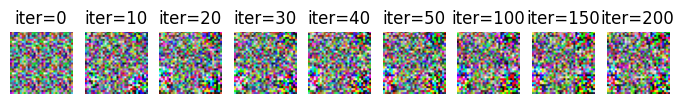

In [7]:
# generate dummy data and label
import time
 
from pytorch_msssim import ssim


#print (ssim(0.43*torch.unsqueeze(gt_data[0],dim=0),torch.unsqueeze(gt_data[0],dim=0),data_range=0).item())
#print (torch.dist(0.6*torch.unsqueeze(gt_data[0],dim=0),torch.unsqueeze(gt_data[0],dim=0),2).item())

for item in range(1):
    start = time.perf_counter()
    for rd in range(1):

        torch.manual_seed(100*rd)
        #dummy_data = torch.unsqueeze(torch.randn(gt_data[item].size()),0).to(device).requires_grad_(True)
        
        #dummy_data = torch.unsqueeze(torch.zeros(gt_data[item].size()),0).to(device).requires_grad_(True)
        #dummy_data = torch.unsqueeze(torch.ones(gt_data[item].size()),0).to(device).requires_grad_(True)

        
        #background = torch.unsqueeze(torch.zeros(gt_data[item].size()),0)
        #background[0,2,::] = 1
        #dummy_data = background.to(device).requires_grad_(True)
        #dummy_data = (torch.unsqueeze(torch.randn(gt_data[item].size()),0)+background).to(device).requires_grad_(True)
        
        #surrogate = torch.unsqueeze(gt_data[item+1],0)
        #aaa = torch.rand([3,16,16])
        #surrogate[0,:,8:24,8:24] =aaa
        #dummy_data = surrogate.to(device).requires_grad_(True)    
        
        #dummy_data = torch.unsqueeze(gt_data[item+1],0).to(device).requires_grad_(True)
        
        #k = np.random.randint(0,95)
        #dummy_data = torch.unsqueeze(gt_data[k],0).to(device).requires_grad_(True)
        
        
        pat_1 = torch.rand([3,16,16])
        pat_2 = torch.cat((pat_1,pat_1),dim=1)
        pat_4 = torch.cat((pat_2,pat_2),dim=2)
        dummy_data = torch.unsqueeze(pat_4,dim=0).to(device).requires_grad_(True)
        
        
        dummy_unsqueeze=torch.unsqueeze(gt_onehot_label[item],dim=0)
        
        dummy_label = torch.randn(dummy_unsqueeze.size()).to(device).requires_grad_(True)
        label_pred=torch.argmin(torch.sum(original_dy_dx[item][-2], dim=-1), 
                                dim=-1).detach().reshape((1,)).requires_grad_(False)
        #print (original_dy_dx[item][-1].shape)
        #print (original_dy_dx[item][-1].argmin())
        
        #print (torch.sum(original_dy_dx[item][-2], dim=-1).argmin())
        
        plt.imshow(tt(dummy_data[0].cpu()))
        plt.title("Dummy data")
        #plt.savefig("./random_seed/index_%s_rand_seed_%s_label_%s"%(item,rd,torch.argmax(dummy_label, dim=-1).item()))

        plt.clf()
        print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())
        print("stolen label is %d." % label_pred.item())
        
        
        #optimizer = torch.optim.LBFGS([dummy_data,dummy_label])
        optimizer = torch.optim.LBFGS([dummy_data,])
        #optimizer = torch.optim.AdamW([dummy_data,],lr=0.01)

        history = []
        
        percept_dis = np.zeros(300)
        recover_dis = np.zeros(300)
        for iters in range(300):
            
          
            percept_dis[iters]=ssim(dummy_data,torch.unsqueeze(gt_data[item],dim=0),data_range=0).item()
            recover_dis[iters]=torch.dist(dummy_data,torch.unsqueeze(gt_data[item],dim=0),2).item()
           
            history.append(tt(dummy_data[0].cpu()))
            def closure():
                optimizer.zero_grad()

                pred = net(dummy_data) 
                #dummy_onehot_label = F.softmax(dummy_label, dim=-1).long()
                
                #dummy_loss = criterion(pred, dummy_onehot_label) # TODO: fix the gt_label to dummy_label in both code and slides.
                #print (pred)
                #print (label_pred)
            
                dummy_loss = criterion(pred, label_pred)
                dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)
                #dummy_dy_dp = torch.autograd.grad(dummy_loss, dummy_data, create_graph=True)
                #print (dummy_dy_dp[0].shape)  

                grad_diff = 0
                grad_count = 0
                #count =0
                for gx, gy in zip(dummy_dy_dx, original_dy_dx[item]): # TODO: fix the variablas here
                   
                    #if iters==500 or iters== 1200:
                    #print (gx[0])
                    #    print ('hahaha')
                    #print (gy[0])
                    lasso = torch.norm(dummy_data,p=1)
                    ridge = torch.norm(dummy_data,p=2)
                    grad_diff += ((gx - gy) ** 2).sum() #+ 0.0*lasso +0.01*ridge 
                    
                    #print (gx.shape)

                    grad_count += gx.nelement()
                

                    #if count == 9:
                    #    break
                    #count=count+1
                # grad_diff = grad_diff / grad_count * 1000
                
                #grad_diff += ((original_pred[item]-pred)**2).sum()
               
                
                
                
                grad_diff.backward()
                #print (count)

                #print (dummy_dy_dx)
                #print (original_dy_dx)


                return grad_diff



            optimizer.step(closure)
            if iters % 5 == 0: 
                current_loss = closure()
                #if iters == 0: 
                print ("%.8f" % current_loss.item())
                #print(iters, "%.8f" % current_loss.item())
            history.append(tt(dummy_data[0].cpu()))

        
        
        #plt.figure(figsize=(18, 12))
        #for i in range(60):
        #  plt.subplot(6, 10, i + 1)
        #  plt.imshow(history[i * 5])
        #  plt.title("iter=%d" % (i * 5))
        #  plt.axis('off')
        
        
        plt.figure(figsize=(8.5, 1.2))
        iter_idx = [0,10,20,30,40,50,100,150,200]
        for i in range(9):
          plt.subplot(1, 9, i + 1)
          plt.imshow(history[iter_idx[i]])
          plt.title("iter=%d" % (iter_idx[i]))
          plt.axis('off')
            
        #np.savetxt('ssim_random_batch8',percept_dis,fmt="%4f")
        #np.savetxt('mse_random_batch8',recover_dis,fmt="%4f")
        
        #print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())
        plt.savefig("./attack_image/index_%s_rand_%s_label_%s"%(item,rd, label_pred.item()))
        #plt.clf()
       
    duration = time.perf_counter()-start
    #print ("Running time is %.4f." %(duration/10.0) )
    print (duration/10.0 )
    
        

In [8]:
def CPL(original_dy_dx, threshhold=0.0001, seed=0):
    for item in range(1):
        start = time.perf_counter()
        for rd in range(1):

            torch.manual_seed(seed)


            pat_1 = torch.rand([3,16,16])
            pat_2 = torch.cat((pat_1,pat_1),dim=1)
            pat_4 = torch.cat((pat_2,pat_2),dim=2)
            dummy_data = torch.unsqueeze(pat_4,dim=0).to(device).requires_grad_(True)


            dummy_unsqueeze=torch.unsqueeze(gt_onehot_label[item],dim=0)

            dummy_label = torch.randn(dummy_unsqueeze.size()).to(device).requires_grad_(True)
            label_pred=torch.argmin(torch.sum(original_dy_dx[item][-2], dim=-1), 
                                    dim=-1).detach().reshape((1,)).requires_grad_(False)


            plt.imshow(tt(dummy_data[0].cpu()))
            plt.title("Dummy data")

            plt.clf()
            print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())
            print("stolen label is %d." % label_pred.item())


            #optimizer = torch.optim.LBFGS([dummy_data,dummy_label])
            optimizer = torch.optim.LBFGS([dummy_data,],lr=1)
            #optimizer = torch.optim.AdamW([dummy_data,],lr=0.01)

            history = []

            percept_dis = np.zeros(300)
            recover_dis = np.zeros(300)
            
            success_iter = 0
            for iters in range(300):


                percept_dis[iters]=ssim(dummy_data,torch.unsqueeze(gt_data[item],dim=0),data_range=0).item()
                recover_dis[iters]=torch.dist(dummy_data,torch.unsqueeze(gt_data[item],dim=0),2).item()

                history.append(tt(dummy_data[0].cpu()))
                def closure():
                    optimizer.zero_grad()

                    pred = net(dummy_data) 
                    #dummy_onehot_label = F.softmax(dummy_label, dim=-1).long()

                    #dummy_loss = criterion(pred, dummy_onehot_label) # TODO: fix the gt_label to dummy_label in both code and slides.
                    #print (pred)
                    #print (label_pred)

                    dummy_loss = criterion(pred, label_pred)
                    dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)
                    #dummy_dy_dp = torch.autograd.grad(dummy_loss, dummy_data, create_graph=True)
                    #print (dummy_dy_dp[0].shape)  

                    grad_diff = 0
                    grad_count = 0
                    #count =0
                    for gx, gy in zip(dummy_dy_dx, original_dy_dx[item]): # TODO: fix the variablas here
                        lasso = torch.norm(dummy_data,p=1)
                        ridge = torch.norm(dummy_data,p=2)
                        grad_diff += ((gx - gy) ** 2).sum() #+ 0.0*lasso +0.01*ridge 
                        grad_count += gx.nelement()

                    grad_diff.backward()

                    return grad_diff
                optimizer.step(closure)
                current_loss = closure()
                if current_loss <= threshhold:
                    print("%.8f" % current_loss.item())
                    print(f"success at {iters} round")
                    success_iter = iters
                    break
                if iters % 10 == 0: 
                    #if iters == 0: 
                    print ("%.8f" % current_loss.item())
                    #print(iters, "%.8f" % current_loss.item())
                history.append(tt(dummy_data[0].cpu()))

        duration = time.perf_counter()-start
        #print ("Running time is %.4f." %(duration/10.0) )
        print (duration/10.0 )
        return success_iter, history

In [11]:
threshhold = 0.0001
batch = 8
labels = [1, 2, 6, 7, 8, 9, 14, 16, 21, 25, 26, 27,  47]
history_list = []
success_num = 0
attack_iter_sum = 0
seed_num = 10
for label in labels:
    idx_m = []

    for s in range(1000):
        if dst_tensor[s][1]==label:   
            idx_m.append(s)
        if len(idx_m)==batch:
            break
    
    original_dy_dx, original_pred = sample_and_calcgrad(idx_m)
    history_tmp = []
    for seed in range(seed_num):
        success_iter, history = CPL(original_dy_dx, threshhold=threshhold, seed=seed)
        if success_iter:
            success_num += 1
            attack_iter_sum += success_iter
        history_tmp.append(history)
    history_list.append(history_tmp)


print(f"ASR is {success_num / (len(labels)*seed_num)}")
print(f"attack iter is {attack_iter_sum / success_num}")



Dummy label is 42.
stolen label is 1.
0.00019440
0.00009503
success
0.03418563231825829
Dummy label is 43.
stolen label is 1.
0.00023746
0.00005282
success
0.05445233732461929
Dummy label is 79.
stolen label is 1.
0.00020145
0.00008492
success
0.043308410048484805
Dummy label is 1.
stolen label is 1.
0.00019290
0.00007966
success
0.03311228305101395
Dummy label is 105.
stolen label is 1.
0.00021572
0.00004788
success
0.0544403113424778
Dummy label is 9.
stolen label is 1.
0.00018416
0.00008033
success
0.0324871800839901
Dummy label is 3.
stolen label is 1.
0.00020603
0.00009830
success
0.03295243084430695
Dummy label is 103.
stolen label is 1.
0.00020024
0.00009318
success
0.03325176537036896
Dummy label is 35.
stolen label is 1.
0.00022533
0.00005633
success
0.05432883724570274
Dummy label is 2.
stolen label is 1.
0.00019488
0.00009195
success
0.03283523321151734
Dummy label is 42.
stolen label is 2.
0.00044770
0.00007225
success
0.07948696762323379
Dummy label is 43.
stolen label is 

0.00005794
success
0.05420644879341126
Dummy label is 103.
stolen label is 21.
0.00016584
0.00009792
success
0.03401720598340034
Dummy label is 35.
stolen label is 21.
0.00017571
0.00006935
success
0.05532776340842247
Dummy label is 2.
stolen label is 21.
0.00016589
0.00009900
success
0.03393788337707519
Dummy label is 42.
stolen label is 25.
0.00122167
0.00008936
success
0.10973369181156159
Dummy label is 43.
stolen label is 25.
0.00144305
0.00007899
success
0.26018314212560656
Dummy label is 79.
stolen label is 25.
0.00129930
0.00007975
success
0.11193391755223274
Dummy label is 1.
stolen label is 25.
0.00128780
0.00007169
success
0.10945257022976876
Dummy label is 105.
stolen label is 25.
0.00171507
0.00009713
success
0.1092130720615387
Dummy label is 9.
stolen label is 25.
0.00100840
0.00009867
success
0.07950936332345009
Dummy label is 3.
stolen label is 25.
0.00138937
0.00008086
success
0.10955892577767372
Dummy label is 103.
stolen label is 25.
0.00199984
0.00009433
success
0.10

<Figure size 640x480 with 0 Axes>

In [16]:
len(history_list[0][0])

3

Dummy label is 42.


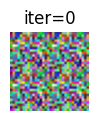

In [19]:
plt.figure(figsize=(12, 8))
for i in range(60):
  plt.subplot(6, 10, i + 1)
  plt.imshow(history_list[0][0][i * 5])
  plt.title("iter=%d" % (i * 5))
  plt.axis('off')
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

In [ ]:
plt.figure(figsize=(12, 8))
for j in range(batch):
    for i in range(60):
      plt.subplot(6, 10, i + 1)
      plt.imshow(history[i * 5+j])
      plt.title("iter=%d" % (i * 5+ j))
      plt.axis('off')
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())